In [1]:
import os
import gc
import json
import yaml
import itertools
import functools
import collections
import numpy as np
import pandas as pd
import colorsys
from typing import Literal, List, Tuple, Dict, Optional, Union
from typing_extensions import get_args

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
from matplotlib.font_manager import FontProperties
import matplotlib.cm as cm

In [2]:
# --------------------------------------------- utility functions --------------------------------------------- #

In [3]:
def load_from_yaml(path_to_file: str):
    with open(path_to_file, 'r') as file:
        data = yaml.safe_load(file)
    return data

# clembench cllm-pair names official format
format_cllm_pairs = lambda model_name: "{0}-t0.0--{1}-t0.0".format(model_name, model_name)

# extract model names from clembench cllm_pairs
extract_model_name = lambda cllm_pair: cllm_pair.split("--")[0].replace("-t0.0", "")

# ensure if given directory exists otherwise create a new directory with specified name.
check_directory_exists = lambda directory_name: os.makedirs(directory_name) if not os.path.exists(directory_name) else None

# darkern color
def darken_color(color, factor=0.5):
    """Darken a color by a given factor."""
    rgb = colorsys.rgb_to_hls(*color[:3])
    return colorsys.hls_to_rgb(rgb[0], max(0, min(1, factor * rgb[1])), rgb[2])

# merge modified and original clembench-runs results files
def merge_results_files(current_results_file: str,
                       original_results_file: str):
    current_results = pd.read_csv(current_results_file)
    original_results = pd.read_csv(original_results_file)
    merged_results = pd.merge(current_results, original_results, how="outer").sort_values(by="Unnamed: 0").reset_index(drop=True)
    merged_results.to_csv("results.csv", index=False)

# merge results.csv files from different branches/developments
def merge_results_csv(directory: str="./Data/") -> None:
    files = os.listdir(directory)
    results_files = [filename for filename in files if filename.startswith("results") and filename.endswith(".csv")]
    if not results_files:
        return None
    merged_df = pd.DataFrame()
    for filename in results_files:
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)
        merged_df = pd.concat([merged_df, df], ignore_index=True)
    merged_df = merged_df.drop_duplicates().reset_index(drop=True)
    save_filename = "./results.csv"
    merged_df.to_csv(os.path.join(directory, save_filename), index=False)

In [4]:
# --------------------------------------------- constants --------------------------------------------- #

In [5]:
_dimension_types = Literal["family", "checkpoints", "further_finetuned", "versions", "quantization"]

# NOTE: Can be updated later
model_acronyms = {
    "qwen1.5-0.5b-chat": "qwen1.5-0.5b",
    "qwen1.5-1.8b-chat": "qwen1.5-1.8b",
    "qwen1.5-7b-chat": "qwen1.5-7b",
    "qwen1.5-14b-chat": "qwen1.5-14b",
    "qwen1.5-32b-chat": "qwen1.5-32b",
    "qwen1.5-72b-chat": "qwen1.5-72b",
    "command-r": "command-r",
    "command-r-plus": "command-r-plus",
    "mixtral-8x7b-instruct-v0.1": "mixtral-8x7b",
    "mixtral-8x22b-instruct-v0.1": "mixtral-8x22b",
    "llama-2-70b-chat-hf": "llama",
    "sheep-duck-llama-2-70b-v1.1": "sheepduck",
    "wizardlm-70b-v1.0": "wizardlm",
    "tulu-2-dpo-70b": "tulu",
    "mistral-7b-instruct-v0.1": "mistral-7b-v0.1",
    "mistral-7b-instruct-v0.2": "mistral-7b-v0.2",
    "zephyr-7b-beta": "zephyr-7b",
    "openchat-3.5": "openchat-3.5",
    "openchat-3.5-1210": "openchat-3.5-1210",
    "openchat-3.5-0106": "openchat-3.5-0106",
    "starling-lm-7b-beta": "starling-lm-7b",
    "gemma-7b-it": "gemma-7b",
    "gemma-1.1-7b-it": "gemma-1.1.b-7b",
    "neural-chat-7b-v3-1": "neural-chat-7b-v3-1",
    "neural-chat-7b-v3-3": "neural-chat-7b-v3-3",
    "gpt-3.5-turbo-0125": "gpt-3.5-0125",
    "gpt-4-0613": "gpt-4-0613",
    "gpt-4-1106-preview": "gpt-4-1106",
    "gpt-4-0125-preview": "gpt-4-0125",
    "claude-2.1": "claude-2.1",
    "claude-3-haiku-20240307": "claude-3-haiku",
    "claude-3-sonnet-20240229": "claude-3-sonnet",
    "claude-3-opus-20240229": "claude-3-opus",
    "meta-llama-3-70b-instruct-gguf-q4": "llama-3-70b-q4",
    "c4ai-command-r-plus-4bit": "command-r-plus-q4",
    "mistral-medium-2312": "mistral-medium",
    "mistral-large-2402": "mistral-large",
    "gemini-1.0-pro": "gemini-1.0-pro",
    "gemini-1.5-flash-latest": "gemini-1.5-flash",
    "gemini-1.5-pro-latest": "gemini-1.5-pro",
    "gpt-4-turbo-2024-04-09": "gpt-4-0409",
    "gpt-4o-2024-05-13": "gpt-4o-0513",
    "nous-hermes-2-mixtral-8x7b-sft": "nous-hermes-2-sft",
    "dolphin-2.5-mixtral-8x7b": "dolphin-2.5",
    "yi-34b-chat": "yi-34b",
    "yi-1.5-34b-chat": "yi-1.5-34b",
    "yi-1.5-9b-chat": "yi-1.5-9b",
    "yi-1.5-6b-chat": "yi-1.5-6b",
    "meta-llama-3-70b-instruct-gguf-q4": "llama-3-70b-gguf-q4",
    "meta-llama-3-70b-instruct-gguf-q8": "llama-3-70b-gguf-q8",
    "meta-llama-3-8b-instruct-gguf-q4": "llama-3-8b-gguf-q4",
    "meta-llama-3-8b-instruct-gguf-q8": "llama-3-8b-gguf-q8",
    "c4ai-command-r-plus-gguf-q4": "command-r-plus-gguf-q4",
    "c4ai-command-r-plus-gguf-q8": "command-r-plus-gguf-q8",
    "meta-llama-3-8b-instruct-hf": "llama-3-8b",
    "meta-llama-3-70b-instruct-hf": "llama-3-70b"
}

game_acronym = {
    "taboo": "taboo",
    "wordle": "wordle",
    "wordle_withclue": "wordle+cl",
    "wordle_withcritic": "wordle+cr",
    "referencegame": "reference",
    "imagegame": "drawing",
    "privateshared": "priv/sh"
}

In [6]:
# ---------------------------------------------- plot functions --------------------------------------------- #

In [7]:
# ---------------------------------------------- bar chart w/ groups ---------------------------------------------- #
def plot_bars_with_groups(data: pd.DataFrame=None,
                          values_column_name: str="value",
                          labels_column_name: str="label",
                          group_column_name: str="group",
                          figure_size: tuple=(30, 8),
                          show_legend: bool=False,
                          rotation: int=90,
                          savefig: bool=False,
                          **kwargs) -> None:

    plt.figure(figsize=figure_size)

    ax = sns.barplot(data=data, x=labels_column_name, y=values_column_name, hue=group_column_name, dodge=False, legend=False, edgecolor="black", width=0.9)
    ax.set_xticks(range(len(data[labels_column_name])))
    ax.set_xticklabels(data[labels_column_name], rotation=rotation)

    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_axisbelow(True)
    ax.grid(color='lightgrey', linestyle='-', linewidth=1, zorder=1)

    legend_handles, legend_labels = [], []

    for group_name, group_data in data.groupby(group_column_name):
        start_pos = ax.patches[data[group_column_name].tolist().index(group_name)].get_x()
        bar_width = ax.patches[data[group_column_name].tolist().index(group_name)].get_width()
        x_positions = [start_pos + bar_width / 2 + i for i in range(len(group_data))]
        bar_color = ax.patches[data[group_column_name].tolist().index(group_name)].get_facecolor()
        darkened_color = darken_color(bar_color)
        plt.plot(x_positions, group_data[values_column_name], marker='o', label=group_name, color=darkened_color, linewidth=2, markersize=6, markeredgecolor='black')
        legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=darkened_color, markersize=10))
        legend_labels.append(group_name)

    if show_legend:
        ax.legend(handles=legend_handles, labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=min(3, len(legend_labels)), fontsize=16, title="")

    if savefig:
        filename = kwargs["filename"]
        plt.savefig(filename, bbox_inches='tight')
    else:
        plt.show()

# ---------------------------------------------- plot grouped barchart with subplots ---------------------------------------------- #
def plot_grouped_barchart_with_subplots(
        df: pd.DataFrame=None, groups_per_subplot: int=3, group_col: str='group', value_col: str='clemscore', label_col: str='model_value',
        fontsize: int=14, figsize: tuple=(14, 12), fontstyle: str='monospace', rotation: int=-45, show_legend: bool=True, legend_ncols: int=6,
        savefig: bool=True, y_lim_min: int=0, y_lim_max: int=60, y_lim_step: int=20, **kwargs
    ) -> None:

    # Determine the number of subplots needed
    unique_groups = df[group_col].unique()
    num_subplots = int(np.ceil(len(unique_groups) / groups_per_subplot))

    # Generate a cycle of colors
    # color_palette = itertools.cycle(['#e0f0d8', '#b5d1ae', '#80ae9a', '#568b87', '#326b77', '#1b485e', '#122740', '#005CB3', '#003D80'])
    # color_palette = itertools.cycle(['#8dd3c7', '#fff2cc', '#bebada', '#fb8072', '#80b1d3', '#fdb462'])
    color_palette = itertools.cycle(['#8dd3c7', '#f5deb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462'])

    group_colors = {group: next(color_palette) for group in unique_groups}

    # Create the figure and subplots
    fig, axs = plt.subplots(num_subplots, 1, figsize=figsize, constrained_layout=True)

    if num_subplots == 1:
        axs = [axs]  # Ensure axs is always a list of axes for consistency

    # Determine the maximum number of bars across all subplots
    max_bars = 0
    for i in range(num_subplots):
        start_idx = i * groups_per_subplot
        end_idx = start_idx + groups_per_subplot
        df_subset = df[df[group_col].isin(unique_groups[start_idx:end_idx])]
        num_bars = df_subset.shape[0]
        if num_bars > max_bars:
            max_bars = num_bars

    for i in range(num_subplots):
        start_idx = i * groups_per_subplot
        end_idx = start_idx + groups_per_subplot
        df_subset = df[df[group_col].isin(unique_groups[start_idx:end_idx])]
        plot_grouped_barchart(axs[i], df_subset.copy(), group_colors, group_col, value_col, label_col, fontsize, fontstyle, rotation, y_lim_min, y_lim_max, y_lim_step, max_bars)

    if show_legend:
        # Create the legend handles for each group
        handles = [plt.Line2D([0], [0], color=group_colors[group], lw=10, label=group) for group in unique_groups]

        # Create the FontProperties instance for the legend
        monospaced_font = FontProperties(family=fontstyle, size=fontsize, weight='bold')

        # Add the legend below all subplots using bbox_to_anchor
        fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.00), ncol=legend_ncols, frameon=False, prop=monospaced_font)

    if savefig:
        save_filename = kwargs.get('save_filename', 'output.png')
        plt.savefig(save_filename, bbox_inches='tight')
    else:
        plt.show()

def plot_grouped_barchart(ax, df, group_colors, group_col, value_col,
                          label_col, fontsize, fontstyle, rotation, y_lim_min=0, y_lim_max=60, y_lim_step=20, max_bars=None):

    unique_groups = df[group_col].unique()

    # Create a new column for x positions with spaces between groups
    x_positions = []
    current_pos = 0

    bar_width = 0.8  # Fixed bar width

    for group in unique_groups:
        group_data = df[df[group_col] == group]
        group_positions = np.arange(current_pos, current_pos + len(group_data))
        x_positions.extend(group_positions)
        current_pos += len(group_data) + 1  # Add 1 for the space between groups

    df.loc[:, 'x_position'] = x_positions

    # Add padding to ensure all subplots have the same width
    if max_bars is not None:
        total_bars = len(x_positions)
        padding_needed = max_bars - total_bars
        if padding_needed > 0:
            last_position = x_positions[-1] if x_positions else 0
            padding_positions = np.arange(last_position + 1, last_position + padding_needed + 1)
            x_positions.extend(padding_positions)
            df = pd.concat([df, pd.DataFrame({group_col: [None]*padding_needed, value_col: [None]*padding_needed, label_col: ['']*padding_needed, 'x_position': padding_positions})])

    # Plot bars
    for group in unique_groups:
        group_data = df[df[group_col] == group]
        bar_color = group_colors.get(group, '#b3b3b3')
        ax.bar(group_data['x_position'], group_data[value_col], color=bar_color, label=group, width=bar_width, zorder=2)

    # Plot lines with large dots and connecting black points
    for group in unique_groups:
        group_data = df[df[group_col] == group]
        ax.plot(group_data['x_position'], group_data[value_col], color='black', marker='o', markersize=7, linestyle='-', linewidth=1, zorder=4)
        ax.scatter(group_data['x_position'], group_data[value_col], color='black', s=10, zorder=5)  # Black dots at the top of the bars

    # Customizing the plot
    ax.grid(True, zorder=0)

    # Set x-ticks to model values with increased fontsize
    monospaced_font = FontProperties(family=fontstyle, size=fontsize, weight='bold')
    ax.set_xticks(df['x_position'])
    ax.set_xticklabels(df[label_col], rotation=rotation, ha='left', rotation_mode='anchor', fontproperties=monospaced_font)

    # Set y-axis limits and ticks
    ax.set_ylim(y_lim_min, y_lim_max)
    ax.set_yticks(np.arange(y_lim_min, y_lim_max+1, y_lim_step))
    ax.set_yticklabels(ax.get_yticks(), fontsize=fontsize, weight='bold')

    # Set y-axis label with increased fontsize
    ax.set_ylabel('')

    # Remove top and right spines, keep left and bottom spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# ---------------------------------------------- polar bar chart w/ groups ---------------------------------------------- #
def plot_polar_bars_with_groups(data: pd.DataFrame=None,
                                values_column_name: str="value",
                                labels_column_name: str="label",
                                group_column_name: str="group",
                                savefig: bool=False,
                                **kwargs) -> None:

    def get_label_rotation(angle, offset):
        # rotation must be specified in degrees
        rotation = np.rad2deg(angle + offset)
        if angle <= np.pi:
            alignment = "right"
            rotation = rotation + 180
        else:
            alignment = "left"
        return rotation, alignment

    def add_labels(angles, values, labels, offset, ax):
        # space between end of the bar and the label
        padding = 4
        for angle, value, label, in zip(angles, values, labels):
            angle = angle
            rotation, alignment = get_label_rotation(angle, offset)
            ax.text(
                x=angle,
                y=value + padding,
                s=label,
                ha=alignment,
                va="center",
                rotation=rotation,
                rotation_mode="anchor"
            )

    VALUES = data[values_column_name].values
    LABELS = data[labels_column_name].values
    GROUP = data[group_column_name].values

    PAD = 3
    ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
    ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
    WIDTH = (2 * np.pi) / len(ANGLES)

    OFFSET = np.pi / 2

    GROUPS_SIZE = [len(i[1]) for i in data.groupby(group_column_name)]

    offset = 0
    IDXS = []
    for size in GROUPS_SIZE:
        IDXS += list(range(offset + PAD, offset + size + PAD))
        offset += size + PAD

    fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": "polar"})

    ax.set_theta_offset(OFFSET)
    ax.set_ylim(-100, 100)
    ax.set_frame_on(False)
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

    COLORS = [f"C{i}" for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]

    ax.bar(
        ANGLES[IDXS], VALUES, width=WIDTH, color=COLORS,
        edgecolor="white", linewidth=2
    )

    add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)

    y_ticks = [i for i in range(0, 101, 10)]

    offset = 0
    for group, size in zip(list(range(1, len(GROUPS_SIZE)+1)), GROUPS_SIZE):
        # add line below bars
        x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
        ax.plot(x1, [-5] * 50, color="#333333")
        # add text to indicate group
        ax.text(
            np.mean(x1), -20, group, color="#333333", fontsize=10,
            fontweight="bold", ha="center", va="center"
        )
        x2 = np.linspace(ANGLES[offset], ANGLES[offset + PAD - 1], num=50)
        for y_tick in y_ticks:
            ax.plot(x2, [y_tick] * 50, color="#bebebe", lw=0.8)
        offset += size + PAD

    for y_tick in y_ticks:
        ax.plot([0, 2 * np.pi], [y_tick] * 2, color="#bebebe", lw=0.8)
        ax.text(2.1 * np.pi, y_tick, str(y_tick), color="#333333", fontsize=8, ha="left", va="center")

    if savefig:
        filename = kwargs["filename"]
        plt.savefig(filename, bbox_inches='tight')
    else:
        plt.show()

# ---------------------------------------------- radar graph ---------------------------------------------- #
def plot_radar_graph(data: dict=None, savefig: bool=False, frame: str="circle",
                     fontsize: int=14, fontstyle: str='monospace', show_legend: bool=True,
                     figsize: tuple=(8, 8), **kwargs) -> None:

    def radar_factory(num_vars, frame='circle'):
        theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)

        class RadarAxes(PolarAxes):
            name = 'radar'

            def __init__(self, *args, **kwargs):
                super().__init__(*args, **kwargs)
                self.set_theta_zero_location('N')

            def fill(self, *args, closed=True, **kwargs):
                return super().fill(closed=closed, *args, **kwargs)

            def plot(self, *args, **kwargs):
                lines = super().plot(*args, **kwargs)
                for line in lines:
                    self._close_line(line)

            def _close_line(self, line):
                x, y = line.get_data()
                if x[0] != x[-1]:
                    x = np.concatenate((x, [x[0]]))
                    y = np.concatenate((y, [y[0]]))
                    line.set_data(x, y)

            def set_varlabels(self, labels):
                self.set_thetagrids(np.degrees(theta), labels, fontsize=fontsize, fontproperties=monospaced_font)

            def _gen_axes_patch(self):
                if frame == 'circle':
                    return Circle((0.5, 0.5), 0.5)
                elif frame == 'polygon':
                    return RegularPolygon((0.5, 0.5), num_vars, radius=.5, edgecolor="k")
                else:
                    raise ValueError("unknown value for 'frame': %s" % frame)

            def draw(self, renderer):
                if frame == 'polygon':
                    gridlines = self.yaxis.get_gridlines()
                    for gl in gridlines:
                        gl.get_path()._interpolation_steps = num_vars
                super().draw(renderer)

            def _gen_axes_spines(self):
                if frame == 'circle':
                    return super()._gen_axes_spines()
                elif frame == 'polygon':
                    spine = Spine(axes=self, spine_type='circle', path=Path.unit_regular_polygon(num_vars))
                    spine.set_transform(Affine2D().scale(.5).translate(.5, .5) + self.transAxes)
                    return {'polar': spine}
                else:
                    raise ValueError("unknown value for 'frame': %s" % frame)

        register_projection(RadarAxes)
        return theta

    N = len(data["spoke_labels"])
    theta = radar_factory(N, frame)
    spoke_labels = data["spoke_labels"]
    labels = data["labels"]
    case_data = data["case_data"]

    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(top=0.85, bottom=0.05)

    # Plot each case
    for i, d in enumerate(case_data):
        ax.plot(theta, d, label=labels[i])
        ax.fill(theta, d, alpha=0.25)

    # Customize the plot
    monospaced_font = FontProperties(family=fontstyle, size=fontsize)
    ax.set_varlabels(spoke_labels)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    # Setting the font properties for the labels
    for label in ax.get_xticklabels():
        label.set_fontproperties(monospaced_font)
    for label in ax.get_yticklabels():
        label.set_fontproperties(monospaced_font)

    if show_legend:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=1, prop=monospaced_font)

    if savefig:
        filename = kwargs.get('save_filename', 'radar_plot.pdf')
        plt.savefig(filename, bbox_inches='tight')
    else:
        plt.show()

# ---------------------------------------------- radar graph with subplots ---------------------------------------------- #

def plot_radar_graph_with_subplots(data_list: list, savefig: bool=False, frame: str="circle",
                                   fontsize: int=14, fontstyle: str='monospace', show_legend: bool=True,
                                   figsize: tuple=(8, 8), ncols: int=2, **kwargs) -> None:

    def radar_factory(num_vars, frame='circle'):
        theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        theta += theta[:1]  # Complete the loop

        class RadarAxes(PolarAxes):
            name = 'radar'

            def __init__(self, *args, **kwargs):
                super().__init__(*args, **kwargs)
                self.set_theta_zero_location('N')

            def fill(self, *args, closed=True, **kwargs):
                return super().fill(closed=closed, *args, **kwargs)

            def plot(self, *args, **kwargs):
                lines = super().plot(*args, **kwargs)
                for line in lines:
                    self._close_line(line)

            def _close_line(self, line):
                x, y = line.get_data()
                if x[0] != x[-1]:
                    x = np.concatenate((x, [x[0]]))
                    y = np.concatenate((y, [y[0]]))
                    line.set_data(x, y)

            def set_varlabels(self, labels):
                self.set_thetagrids(np.degrees(theta[:-1]), labels, fontsize=fontsize, fontproperties=monospaced_font)

            def _gen_axes_patch(self):
                if frame == 'circle':
                    return Circle((0.5, 0.5), 0.5)
                elif frame == 'polygon':
                    return RegularPolygon((0.5, 0.5), num_vars, radius=.5, edgecolor="k")
                else:
                    raise ValueError(f"unknown value for 'frame': {frame}")

            def draw(self, renderer):
                if frame == 'polygon':
                    gridlines = self.yaxis.get_gridlines()
                    for gl in gridlines:
                        gl.get_path()._interpolation_steps = num_vars
                super().draw(renderer)

            def _gen_axes_spines(self):
                if frame == 'circle':
                    return super()._gen_axes_spines()
                elif frame == 'polygon':
                    spine = Spine(axes=self, spine_type='circle', path=Path.unit_regular_polygon(num_vars))
                    spine.set_transform(Affine2D().scale(.5).translate(.5, .5) + self.transAxes)
                    return {'polar': spine}
                else:
                    raise ValueError(f"unknown value for 'frame': frame")

        register_projection(RadarAxes)
        return theta

    num_plots = len(data_list)
    nrows = int(np.ceil(num_plots / ncols))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(top=0.85, bottom=0.05, hspace=0.4, wspace=0.4)  # Adjust spacing here

    monospaced_font = FontProperties(family=fontstyle, size=fontsize)
    axs = axs.flatten()

    colormap = plt.colormaps['tab10']

    for idx, data in enumerate(data_list):
        N = len(data["spoke_labels"])
        theta = radar_factory(N, frame)
        spoke_labels = data["spoke_labels"]
        labels = data["labels"]
        case_data = data["case_data"]

        ax = axs[idx]
        for i, d in enumerate(case_data):
            color = colormap(i % 10)
            ax.plot(theta, d + d[:1], label=labels[i], color=color)
            ax.fill(theta, d + d[:1], color=color, alpha=0.25)

        ax.set_varlabels(spoke_labels)
        ax.tick_params(axis='both', which='major', labelsize=fontsize)

        # Set y-ticks
        ax.set_yticks([0, 20, 40, 60, 80, 100])
        ax.set_ylim(0, 100)

        for label in ax.get_xticklabels():
            label.set_fontproperties(monospaced_font)
        for label in ax.get_yticklabels():
            label.set_fontproperties(monospaced_font)

        if show_legend:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=2, prop=monospaced_font)

    # Hide any unused subplots
    for ax in axs[num_plots:]:
        ax.set_visible(False)

    if savefig:
        filename = kwargs.get('save_filename', 'radar_plot.pdf')
        plt.savefig(filename, bbox_inches='tight')
    else:
        plt.show()

In [8]:
class CLEMBENCH_GRAPHICS:
    def __init__(self,
                 path_to_results_file: str="./Data/results.csv",
                 path_to_model_config_file: str="./Data/model_config.yaml"):
        self.path_to_results_file = path_to_results_file
        self.path_to_model_config_file = path_to_model_config_file
        self.valid_dimensions = list(get_args(_dimension_types)) # global variable accessible via constants
        self.model_abbreviations = model_acronyms # global variable accessible via constants
        self.game_abbreviations = game_acronym # global variable accessible via constants
        self._setup()

    def _setup(self):
        # ensure directory "./Plots & ./Results" exists
        _ = [check_directory_exists(directory_name) for directory_name in ["./Plots", "./Results"]]
        self.results_df = pd.read_csv(self.path_to_results_file)
        self.config_data = load_from_yaml(self.path_to_model_config_file)
        self.results_df.rename(columns={
            "Unnamed: 0": "cllm_pairs",
            "-, clemscore": "clemscore"
        }, inplace=True)
        self.results_df["cllm_pairs"] = self.results_df.apply(
            lambda row: row["cllm_pairs"].lower().replace("_", "-").strip(),
            axis=1
        ) # pre-process to specific format
        self.results_df = self.results_df.sort_values(by="cllm_pairs")
        # selecting the color palette
        sns.set_palette("pastel")

    def align_results_w_selected_models(self, filename: str=None, select_all_cols: bool=True):
        selected_models_df = pd.read_csv(filename)
        selected_models_df['Model Name'] = selected_models_df.apply(lambda row: row['Model Name'].strip(), axis=1)
        new_cols_list = ['Model Name'] + self.results_df.columns.tolist()
        self.results_df['Model Name'] = self.results_df.apply(lambda row: extract_model_name(row['cllm_pairs']), axis=1)
        self.results_df = self.results_df[new_cols_list]
        self.results_df.reset_index(drop=True, inplace=True)
        selected_models_df['index'] = range(len(selected_models_df))
        merged_df = pd.merge(selected_models_df, self.results_df, on="Model Name", how="left")
        merged_df = merged_df.sort_values('index').reset_index(drop=True)
        merged_df = merged_df.drop('index', axis=1)
        if not select_all_cols:
            merged_df = merged_df[['Model Provider', 'Model Name', 'clemscore']] # note: can further add columns from results file based on requirement
        merged_df.to_csv("./Results/clembench_model_scores.csv", index=False)

    def bars_with_groups(self, dimension_type: _dimension_types="family", figure_size: int=(10, 8),
                         rotation: int=0, fontsize: int=20, show_legend: bool=False,
                         abbrv_model_names: bool=False):

        if dimension_type in ["family", "versions", "further_finetuned", "quantization"]:
            model_infos = list(itertools.chain.from_iterable([model_info for group in self.config_data[dimension_type] for group_data in group.values() for model_info in group_data]))
            model_names = [model_info["name"] for model_info in model_infos]
            model_values = [model_info["value"] for model_info in model_infos]

            clemscores = [self.results_df[self.results_df["cllm_pairs"] == format_cllm_pairs(model_name)].iloc[0]["clemscore"] if not self.results_df[self.results_df["cllm_pairs"] == format_cllm_pairs(model_name)].empty else 0
                          for model_name in model_names]
            model_2_clemscores = dict(zip(model_names, clemscores))
            groups = list(itertools.chain.from_iterable([list(group.keys())*len(list(group.values())[0]) for group in self.config_data[dimension_type]]))

            plot_data = collections.defaultdict(list)
            plot_data["group"].extend(groups)
            plot_data["model_name"].extend(model_names)
            plot_data["model_value"].extend(model_values)
            plot_data["clemscore"].extend([model_2_clemscores[model_name] for model_name in model_names])
            plot_df = pd.DataFrame(plot_data)
            plot_df["model_acronym"] = plot_df.apply(
                lambda row: self.model_abbreviations[row["model_name"]],
                axis=1
            )

            values_colname = "clemscore"
            labels_colname = "model_value"
            group_colname = "group"

            del model_infos
            del model_values
        else:
            model_names = list(itertools.chain.from_iterable([model for group in self.config_data[dimension_type] for model in group.values()]))
            clemscores = [self.results_df[self.results_df["cllm_pairs"] == format_cllm_pairs(model_name)].iloc[0]["clemscore"] if not self.results_df[self.results_df["cllm_pairs"] == format_cllm_pairs(model_name)].empty else 0
                          for model_name in model_names]
            model_2_clemscores = dict(zip(model_names, clemscores))
            groups = list(itertools.chain.from_iterable([list(group.keys())*len(list(group.values())[0]) for group in self.config_data[dimension_type]]))

            plot_data = collections.defaultdict(list)
            plot_data["group"].extend(groups)
            plot_data["model_name"].extend(model_names)
            plot_data["clemscore"].extend([model_2_clemscores[model_name] for model_name in model_names])
            plot_df = pd.DataFrame(plot_data)
            plot_df["model_acronym"] = plot_df.apply(
                lambda row: self.model_abbreviations[row["model_name"]],
                axis=1
            )

            values_colname = "clemscore"
            labels_colname = "model_name"
            group_colname = "group"
            if abbrv_model_names:
                labels_colname = "model_acronym"
            figure_size = (12, 8)
            show_legend = False
            rotation = 90

        save_filename = "{}_barchart_with_groups.pdf".format(dimension_type)

        plot_bars_with_groups(data=plot_df,
                              values_column_name=values_colname,
                              labels_column_name=labels_colname,
                              group_column_name=group_colname,
                              figure_size=figure_size,
                              fontsize=fontsize,
                              rotation=rotation,
                              show_legend=show_legend,
                              savefig=True,
                              filename=save_filename)

        del clemscores
        del model_2_clemscores
        del groups
        del plot_data
        gc.collect()

    def grouped_barchart_with_subplots(
            self, dimension_type: _dimension_types="family", groups_per_subplot: int=3, fontsize: int=24,
            figsize: tuple=(14, 10), fontstyle: str='monospace', rotation: int=-45, show_legend: bool=True, legend_ncols: int=6,
            savefig: bool=True, **kwargs
        ):

        model_infos = list(itertools.chain.from_iterable([model_info for group in self.config_data[dimension_type] for group_data in group.values() for model_info in group_data]))
        model_names = [model_info["name"] for model_info in model_infos]
        model_values = [model_info["value"] for model_info in model_infos]

        clemscores = [self.results_df[self.results_df["cllm_pairs"] == format_cllm_pairs(model_name)].iloc[0]["clemscore"] if not self.results_df[self.results_df["cllm_pairs"] == format_cllm_pairs(model_name)].empty else 0
                        for model_name in model_names]
        model_2_clemscores = dict(zip(model_names, clemscores))
        groups = list(itertools.chain.from_iterable([list(group.keys())*len(list(group.values())[0]) for group in self.config_data[dimension_type]]))

        plot_data = collections.defaultdict(list)
        plot_data["group"].extend(groups)
        plot_data["model_name"].extend(model_names)
        plot_data["model_value"].extend(model_values)
        plot_data["clemscore"].extend([model_2_clemscores[model_name] for model_name in model_names])
        plot_df = pd.DataFrame(plot_data)

        value_col = "clemscore"
        label_col = "model_value"
        group_col = "group"

        save_filename = "./Plots/{}_barchart_with_groups_subplots.pdf".format(dimension_type)

        if all(key in kwargs for key in ['y_lim_min', 'y_lim_max', 'y_lim_step']):
            y_lim_min, y_lim_max, y_lim_step = kwargs['y_lim_min'], kwargs['y_lim_max'], kwargs['y_lim_step']
        else:
            y_lim_min, y_lim_max, y_lim_step = 0, 60, 20

        plot_grouped_barchart_with_subplots(
            plot_df, groups_per_subplot=groups_per_subplot, group_col=group_col, value_col=value_col, label_col=label_col,
            fontsize=fontsize, figsize=figsize, fontstyle=fontstyle, rotation=rotation, show_legend=show_legend, legend_ncols=legend_ncols,
            savefig=savefig, save_filename=save_filename, y_lim_min=y_lim_min, y_lim_max=y_lim_max, y_lim_step=y_lim_step
        )

        del model_infos
        del model_values
        del clemscores
        del model_2_clemscores
        del groups
        del plot_data
        gc.collect()

    def polar_bars_with_groups(self, dimension_type: _dimension_types="family", abbrv_model_names: bool=False):

        models = list(itertools.chain.from_iterable([model for group in self.config_data[dimension_type] for model in group.values()]))
        clemscores = [self.results_df[self.results_df["cllm_pairs"] == format_cllm_pairs(model)].iloc[0]["clemscore"]
                      for model in models]
        model_2_clemscores = dict(zip(models, clemscores))
        groups = list(itertools.chain.from_iterable([list(group.keys())*len(list(group.values())[0]) for group in self.config_data[dimension_type]]))

        plot_data = collections.defaultdict(list)
        plot_data["group"].extend(groups)
        plot_data["model"].extend(models)
        plot_data["clemscore"].extend([model_2_clemscores[model] for model in models])
        plot_df = pd.DataFrame(plot_data)
        plot_df["model_acronym"] = plot_df.apply(
            lambda row: self.model_abbreviations[row["model"]],
            axis=1
        )

        save_filename = "./Plots/{}_polar_barchart_with_groups.pdf".format(dimension_type)

        values_colname = "clemscore"
        labels_colname = "model"
        group_colname = "group"
        if abbrv_model_names:
            labels_colname = "model_acronym"

        plot_polar_bars_with_groups(data=plot_df,
                                    values_column_name=values_colname,
                                    labels_column_name=labels_colname,
                                    group_column_name=group_colname,
                                    savefig=True,
                                    filename=save_filename)
        del model_names
        del clemscores
        del model_2_clemscores
        del groups
        del plot_data
        gc.collect()

    def radar_graph(self, frame: str="circle", figsize: tuple=(14, 10),
                    fontsize: int=26, fontstyle: str='monospace', show_legend: bool=True,
                    games: List[str]=None, models: List[str]=None,
                    abbrv_game_names: bool=False, abbrv_model_names: bool=False,
                    save_filename: str=None):

        games = ["taboo", "wordle", "wordle_withclue", "wordle_withcritic", "referencegame", "imagegame", "privateshared"] if not games else games

        filtered_data = [self.results_df[self.results_df["cllm_pairs"] == format_cllm_pairs(model)].iloc[0] for model in models]
        case_data = [[0 if np.isnan(score) else score for score in map(functools.partial(lambda r, label: r["{}, Quality Score".format(label)], row), games)]
                     for row in filtered_data]

        if abbrv_game_names:
            games = [self.game_abbreviations[game] for game in games]
        if abbrv_model_names:
            models = [self.model_abbreviations[model] for model in models]
        plot_data = {
            "spoke_labels": games,
            "labels": models,
            "case_data": case_data
        }

        plot_radar_graph(data=plot_data,
                         frame=frame,
                         figsize=figsize,
                         fontsize=fontsize,
                         fontstyle=fontstyle,
                         show_legend=show_legend,
                         savefig=True,
                         save_filename=save_filename)

        del models
        del games
        del filtered_data
        del case_data
        del plot_data
        gc.collect()

    def radar_graph_with_subplots(self, dimension_type: _dimension_types="family",
                                  frame: str="circle", figsize: tuple=(14, 10), ncols: int=3,
                                  fontsize: int=26, fontstyle: str='monospace', show_legend: bool=True,
                                  games: List[str]=None, models: List[str]=None,
                                  abbrv_game_names: bool=False, abbrv_model_names: bool=False,
                                  save_filename: str=None):

        groups_data = self.config_data[dimension_type]
        group2models_map = collections.defaultdict(list)
        for group_data in groups_data:
            group_name = next(iter(group_data))
            model_names = [item[0]["name"] for item in group_data[group_name]]
            group2models_map[group_name] = model_names

        games = ["taboo", "wordle", "wordle_withclue", "wordle_withcritic", "referencegame", "imagegame", "privateshared"] if not games else games

        groups_plot_data = []
        for group_name, models in group2models_map.items():
            filtered_data = [self.results_df[self.results_df["cllm_pairs"] == format_cllm_pairs(model)].iloc[0] for model in models]
            case_data = [[0 if np.isnan(score) else score for score in map(functools.partial(lambda r, label: r["{}, Quality Score".format(label)], row), games)]
                            for row in filtered_data]

            _games = games
            if abbrv_game_names:
                _games = [self.game_abbreviations[game] for game in games]
            if abbrv_model_names:
                models = [self.model_abbreviations[model] for model in models]
            plot_data = {
                "spoke_labels": _games,
                "labels": models,
                "case_data": case_data
            }
            groups_plot_data.append(plot_data)

        plot_radar_graph_with_subplots(data_list=groups_plot_data,
                                       frame=frame,
                                       ncols=ncols,
                                       figsize=figsize,
                                       fontsize=fontsize,
                                       fontstyle=fontstyle,
                                       show_legend=show_legend,
                                       savefig=True,
                                       save_filename=save_filename)

        del groups_data
        del group2models_map
        del models
        del games
        del filtered_data
        del case_data
        del plot_data
        del groups_plot_data
        gc.collect()

In [9]:
# ---------------------------------------------- merge incoming results.csv files ---------------------------------------------- #

# keep the format of the files as "results_XYZ.csv"
# The code will merge all the files and save the output as "results.csv" which can be utilized for further analyis and graphical visualizations
merge_results_csv()

In [10]:
clembench_graphics = CLEMBENCH_GRAPHICS() # initialization

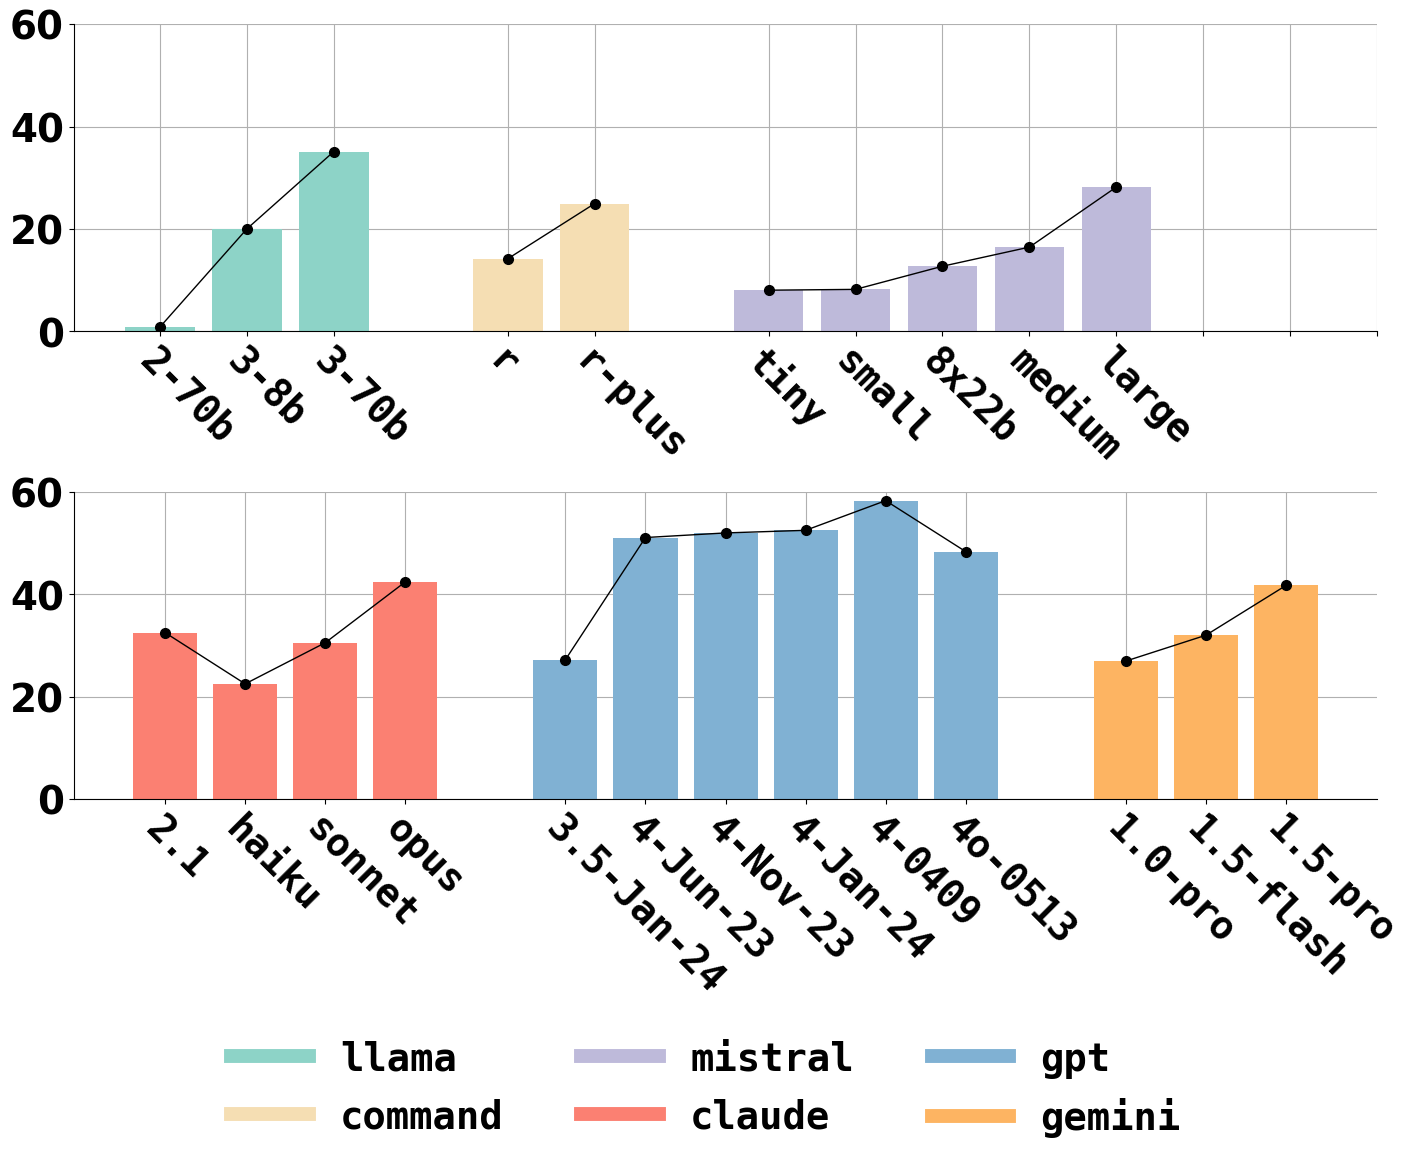

In [11]:
# ---------------------------------------------- plot group barchart with subplots ---------------------------------------------- #

# grouped barchat with subplots
# dimension type "family", "further_finetuned", "versions", "quantization", "additional"
# Note for dimension "family, versions" (figsize = (14, 10)) & "further_finetuned, quantization, additional" (figsize = (14, 5))
clembench_graphics.grouped_barchart_with_subplots(
    dimension_type="family", groups_per_subplot=3, fontsize=28, figsize=(14, 10),
    fontstyle='monospace', rotation=-45, show_legend=True, legend_ncols=3,
    savefig=True, y_lim_min=0, y_lim_max=60, y_lim_step=20
)

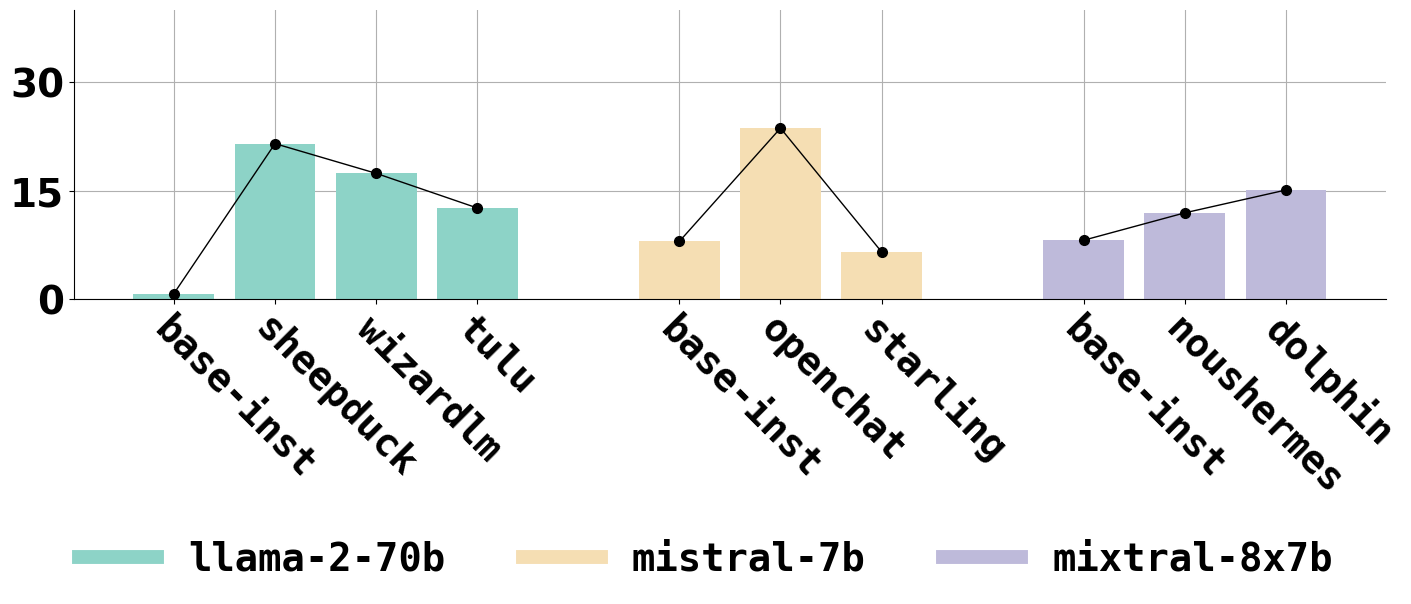

In [12]:
# ---------------------------------------------- plot group barchart with subplots ---------------------------------------------- #

# grouped barchat with subplots
# dimension type "family", "further_finetuned", "versions", "quantization", "additional"
# Note for dimension "family, versions" (figsize = (14, 10)) & "further_finetuned, quantization, additional" (figsize = (14, 5))
clembench_graphics.grouped_barchart_with_subplots(
    dimension_type="further_finetuned", groups_per_subplot=3, fontsize=28, figsize=(14, 5),
    fontstyle='monospace', rotation=-45, show_legend=True, legend_ncols=3,
    savefig=True, y_lim_min=0, y_lim_max=40, y_lim_step=15
)

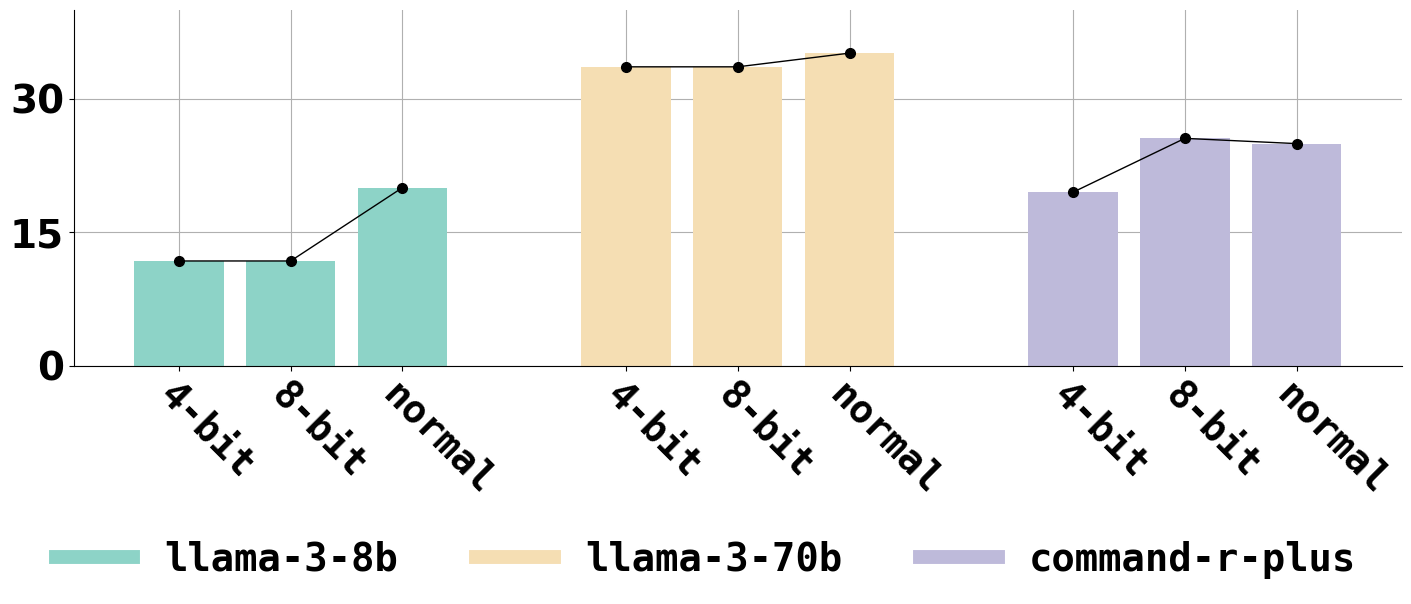

In [13]:
# ---------------------------------------------- plot group barchart with subplots ---------------------------------------------- #

# grouped barchat with subplots
# dimension type "family", "further_finetuned", "versions", "quantization", "additional"
# Note for dimension "family, versions" (figsize = (14, 10)) & "further_finetuned, quantization, additional" (figsize = (14, 5))
clembench_graphics.grouped_barchart_with_subplots(
    dimension_type="quantization", groups_per_subplot=3, fontsize=28, figsize=(14, 5),
    fontstyle='monospace', rotation=-45, show_legend=True, legend_ncols=3,
    savefig=True, y_lim_min=0, y_lim_max=40, y_lim_step=15
)

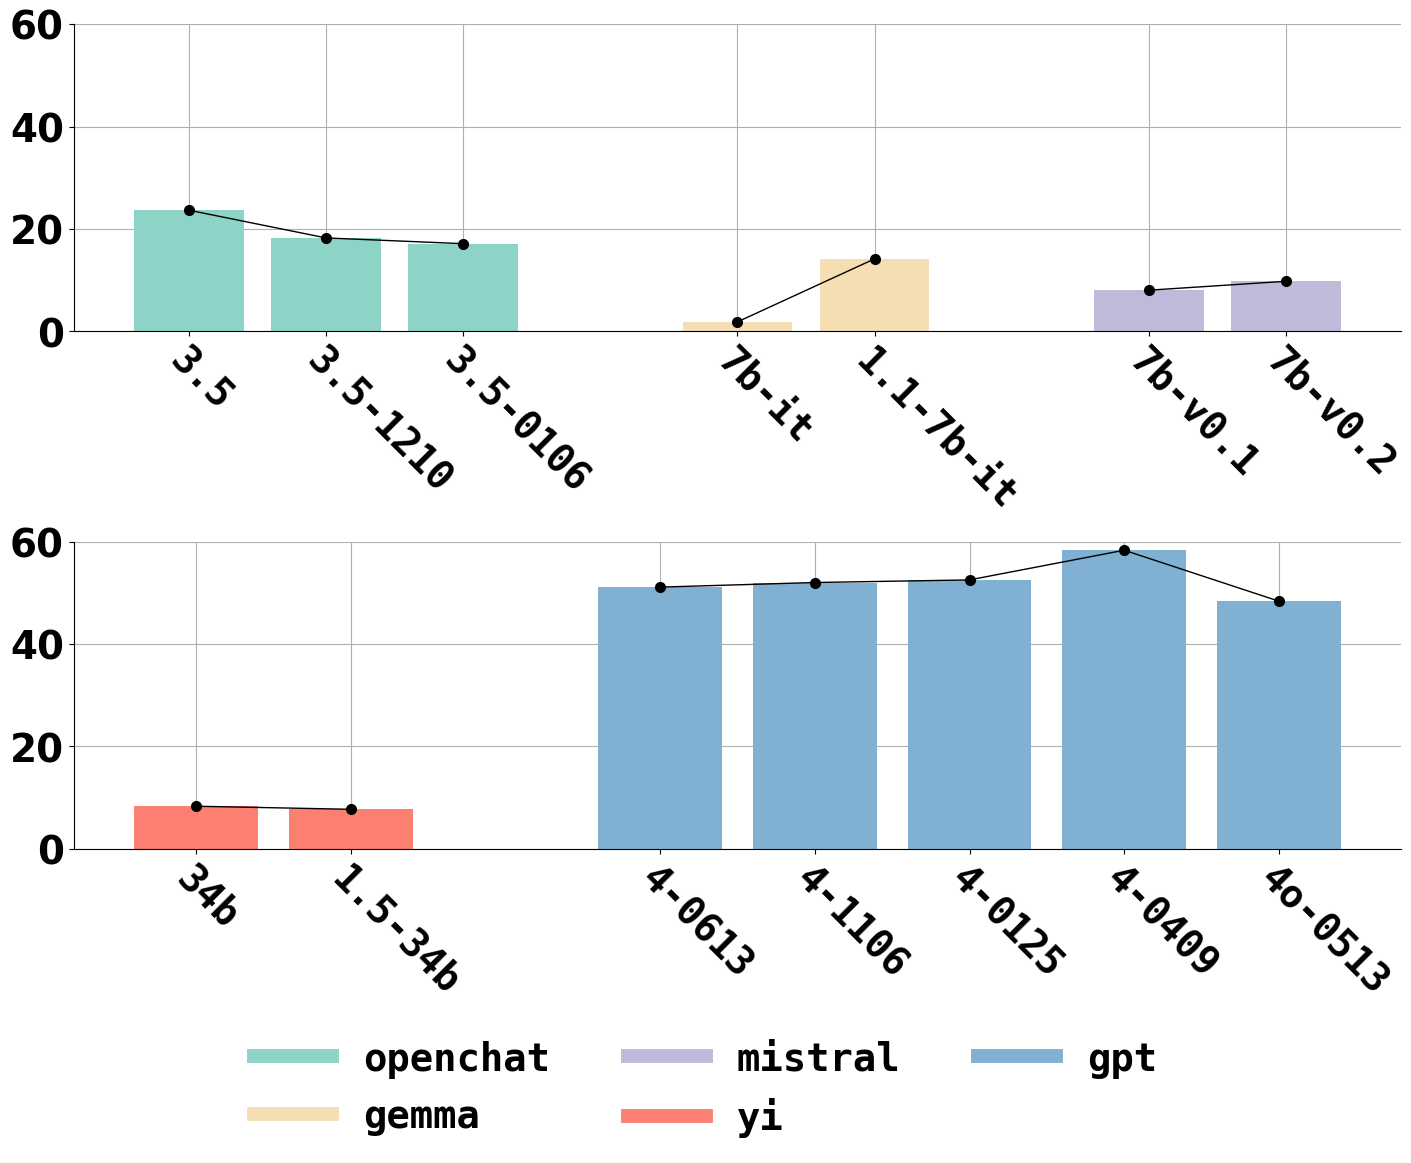

In [14]:
# ---------------------------------------------- plot group barchart with subplots ---------------------------------------------- #

# grouped barchat with subplots
# dimension type "family", "further_finetuned", "versions", "quantization", "additional"
# Note for dimension "family, versions" (figsize = (14, 10)) & "further_finetuned, quantization, additional" (figsize = (14, 5))
clembench_graphics.grouped_barchart_with_subplots(
    dimension_type="versions", groups_per_subplot=3, fontsize=28, figsize=(14, 10),
    fontstyle='monospace', rotation=-45, show_legend=True, legend_ncols=3,
    savefig=True, y_lim_min=0, y_lim_max=60, y_lim_step=20
)

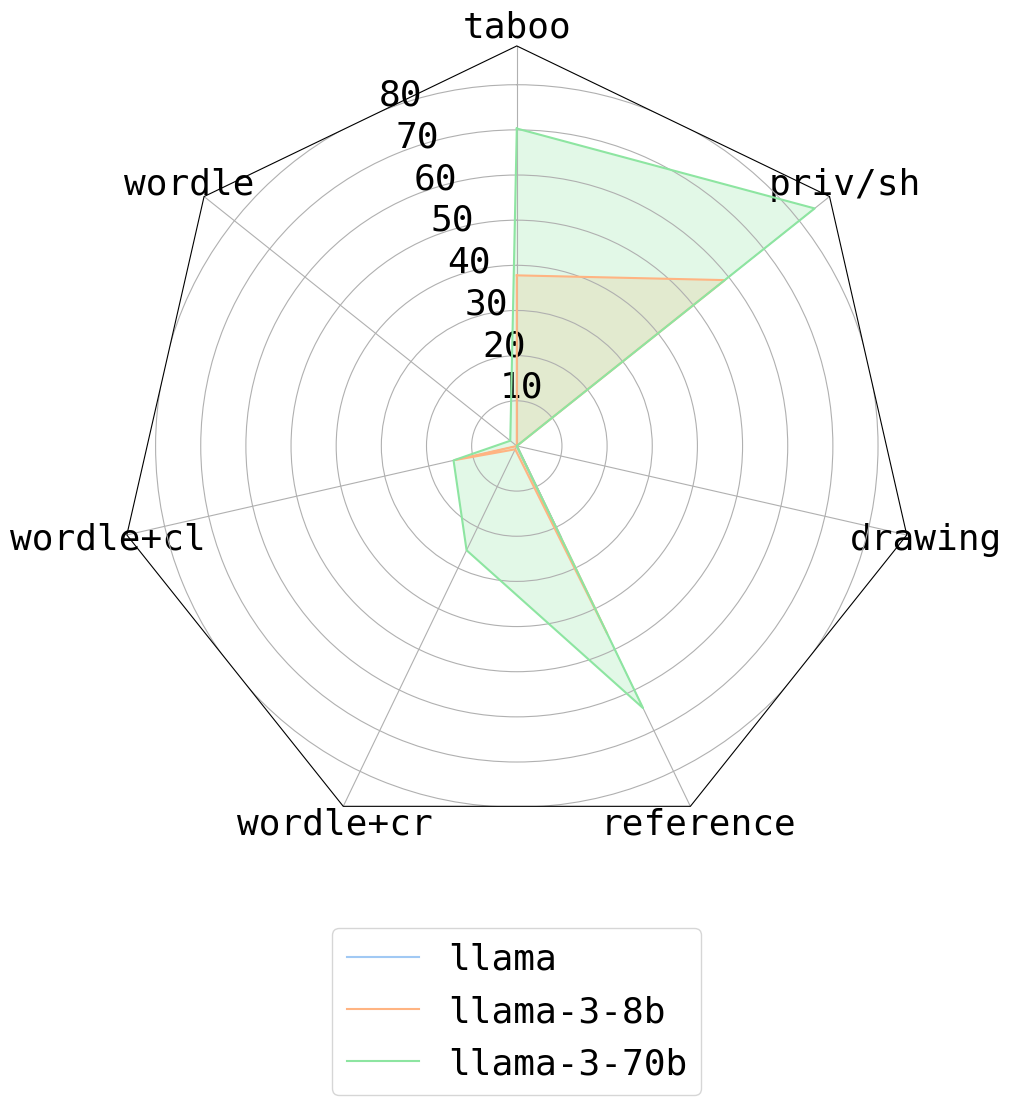

In [15]:
# ---------------------------------------------- plot radar graph ---------------------------------------------- #

# radargraph [NORMAL]
clembench_graphics.radar_graph(
    frame="polygon", figsize=(14, 10), fontsize=26, fontstyle='monospace',
    show_legend=True, models=['llama-2-70b-chat-hf', 'meta-llama-3-8b-instruct-hf', 'meta-llama-3-70b-instruct-hf'],
    abbrv_game_names=True, abbrv_model_names=True,
    save_filename="./Plots/open2commercial_radarchart.pdf"
)

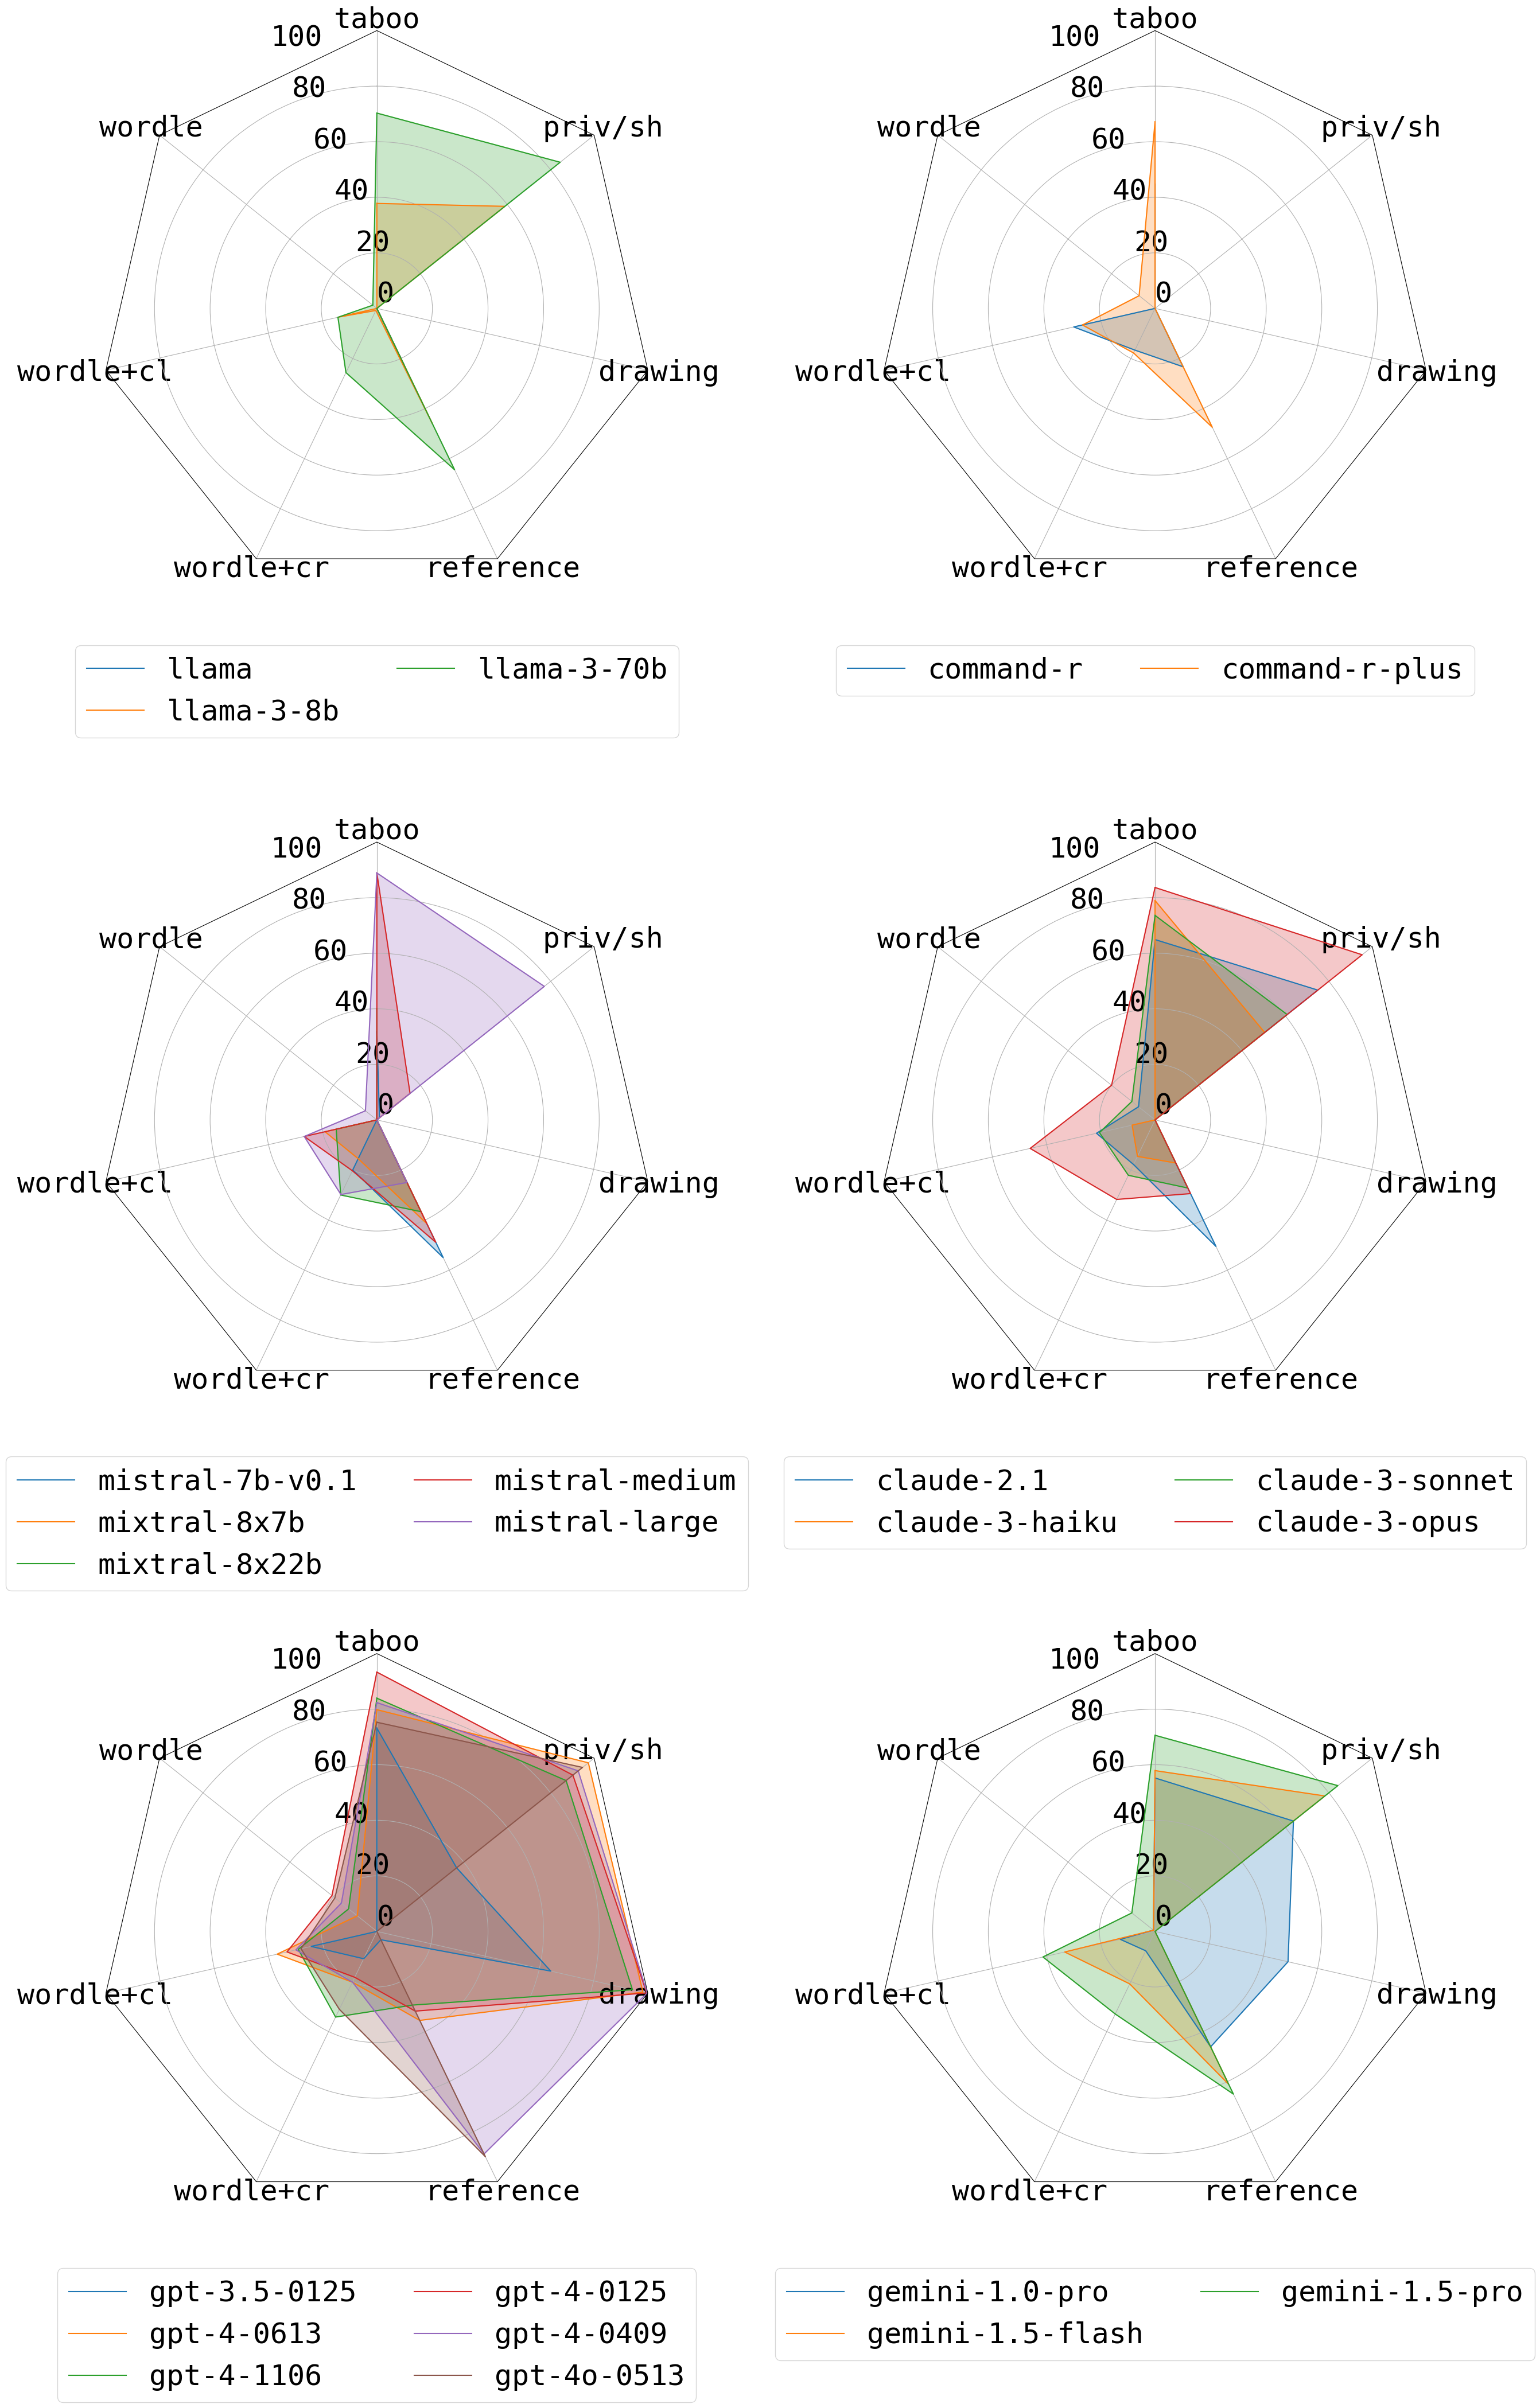

In [16]:
# ---------------------------------------------- plot radar graph with subplots ---------------------------------------------- #

# radar graph with subplots
# dimension type "family", "further_finetuned", "versions", "quantization", "additional"
# Note for dimension "family, versions" (figsize = (30, 48)) & "further_finetuned, quantization, additional" (figsize = (30, 28))
clembench_graphics.radar_graph_with_subplots(
    dimension_type="family",
    frame="polygon", figsize=(30, 48), fontsize=36, fontstyle='monospace',
    show_legend=True, ncols=2,
    abbrv_game_names=True, abbrv_model_names=True,
    save_filename="./Plots/quantization_radarchart_2cols.pdf"
)

In [17]:
# ---------------------------------------------- .csv formatted data for further analysis ---------------------------------------------- #
clembench_graphics = CLEMBENCH_GRAPHICS()

# selected models file for merging available here as gsheets (https://docs.google.com/spreadsheets/d/1J43mpWaquKRqv1zFgnuzfapiRFkVLNPtCa7vYVu_S6w/edit#gid=1744332584)
clembench_graphics.align_results_w_selected_models("./Data/selected_models.csv")

In [ ]:
clembench_model_scores = pd.read_csv("./Results/clembench_model_scores.csv")

# model with all characteristics file available here as gsheets (https://docs.google.com/spreadsheets/d/1J43mpWaquKRqv1zFgnuzfapiRFkVLNPtCa7vYVu_S6w/edit#gid=0)
model_characteristics = pd.read_csv("./Results/model_characteristics.csv") # Does not incl. inference interface models and quantized models